 # An Example of using `minimod`
 For this notebook, we will first create the data needs to be used for the program. Then we will instantiate the class and make a report of the results using the `report` method

In [7]:
import sys
import pandas as pd
import geopandas as gpd

import minimod as mm


In [2]:

# Data

# This is how the data was processed, assuming we use the Katie_VA_Benefits_and_Costs_1_8_2019.xlsx file.
excel_file = "/home/lordflaron/Documents/GAMS-Python/Cameroon VA/GAMS_Working/GAMS_R Project/Katie_VA_Benefits_and_Costs_1_8_2019.xlsx"

## Get "vasoilold" and get discounted benefits for constraint

In [13]:

df_benefit = (pd.read_excel(excel_file,
                           sheet_name = 'Benefits',
                           header = 2)
              .loc[lambda df: df['intervention'] != 'vasoilold']
              .set_index(['intervention', 'space'])
              .stack()
              .to_frame()
              .reset_index()
              .rename({'level_2' : 'time',
                       0 : 'benefit'}, axis=1)
              .set_index(['intervention', 'space', 'time'])
              )

df_cost = (pd.read_excel(excel_file,
                           sheet_name = 'Costs',
                           header = 2)
           .loc[lambda df: df['intervention'] != 'vasoilold']
              .set_index(['intervention', 'space'])
              .stack()
              .to_frame()
              .reset_index()
              .rename({'level_2' : 'time',
                       0 : 'costs'}, axis=1)
              .set_index(['intervention', 'space', 'time'])
              )


df = (df_benefit
    .merge(df_cost, left_index=True, right_index=True))

 Then we merge the cost and benefit data together.



 Then we save the data. The finished data can be found in the `/examples/data` folder.
 `df.to_csv("./data/example1.csv")``

In [16]:
df

benefit         costs
intervention    space  time                             
vas             Cities 1      91831.707333  1.615631e+05
                       2      93729.442747  1.649019e+05
                       3      95545.513047  1.680970e+05
                       4      97257.201155  1.711084e+05
                       5      98888.572892  1.739785e+05
...                                    ...           ...
vasoilcubemaize South  6     727235.621849  1.604656e+06
                       7     737825.923417  1.625568e+06
                       8     747892.128948  1.652558e+06
                       9     757579.575999  1.679405e+06
                       10    767117.855782  1.879107e+06

[450 rows x 2 columns]

 ## Running the model
 Now we instantiate the model, and then run `fit` and get the report.

In [18]:
c = mm.Minimod(solver_type = 'costmin', 
                data = df,
                benefit_col = 'benefit',
                cost_col = 'costs',
               show_output = False,
               minimum_benefit = 'vasoil')


In [19]:

opt = c.fit(data = df, 
            all_space = ['cube', 'oil', 'maize'], 
            all_time = ['maize', 'cube'],
            time_subset = [1,2,3]
            )

In [20]:

c.report()



+----------------------------+----------------------------+
| MiniMod Solver Results     |                            |
| Method:                    | MIN                        |
| Solver:                    | CBC                        |
| Optimization Status:       | OptimizationStatus.OPTIMAL |
| Number of Solutions Found: | 1                          |
+----------------------------+----------------------------+
+-----------------------------+-----+
| No. of Variables:           | 450 |
| No. of Integer Variables:   | 450 |
| No. of Constraints          |  31 |
| No. of Non-zeros in Constr. | 882 |
+-----------------------------+-----+
Interventions Chosen:
+------------------+-------------+
| Minimum Benefit  | 1.65541e+07 |
| Objective Bounds | 2.01269e+07 |
| Total Cost       | 2.01269e+07 |
| Total Benefits   | 1.65732e+07 |
+------------------+-------------+
+------------------+---------+
| Cost per Benefit | 1.21442 |
+------------------+---------+
+--------------------------

In [ ]:
c.write("model.lp")


In [ ]:
c.plot_opt_val_hist(save = "hello.png")

c.plot_time(save = "hello2.png")


 ## Plotting a Map
 Now let's create a chloropleth map of the optimal values from the optimization

In [22]:

# Load data
geo_df = gpd.read_file("examples/data/maps/cameroon/CAM.shp")

# Now we create the boundaries for North, South and Cities
# Based on "Measuring Costs of Vitamin A..., Table 2"
north = r"Adamaoua|Nord|Extreme-Nord"
south = r"Centre|Est|Nord-Ouest|Ouest|Sud|Sud-Ouest"
cities= r"Littoral" # Duala
# Yaounde is in Mfoundi
geo_df.loc[lambda df: df['ADM1'].str.contains(north), 'space'] = 'North'
geo_df.loc[lambda df: df['ADM1'].str.contains(south), 'space'] = 'South'
geo_df.loc[lambda df: df['ADM1'].str.contains(cities), 'space'] = 'Cities'
geo_df.loc[lambda df: df['ADM2'].str.contains(r"Mfoundi"), 'space'] = 'Cities'

# Now we aggregate the data to the `space` variable
agg_geo_df = geo_df.dissolve(by = 'space')


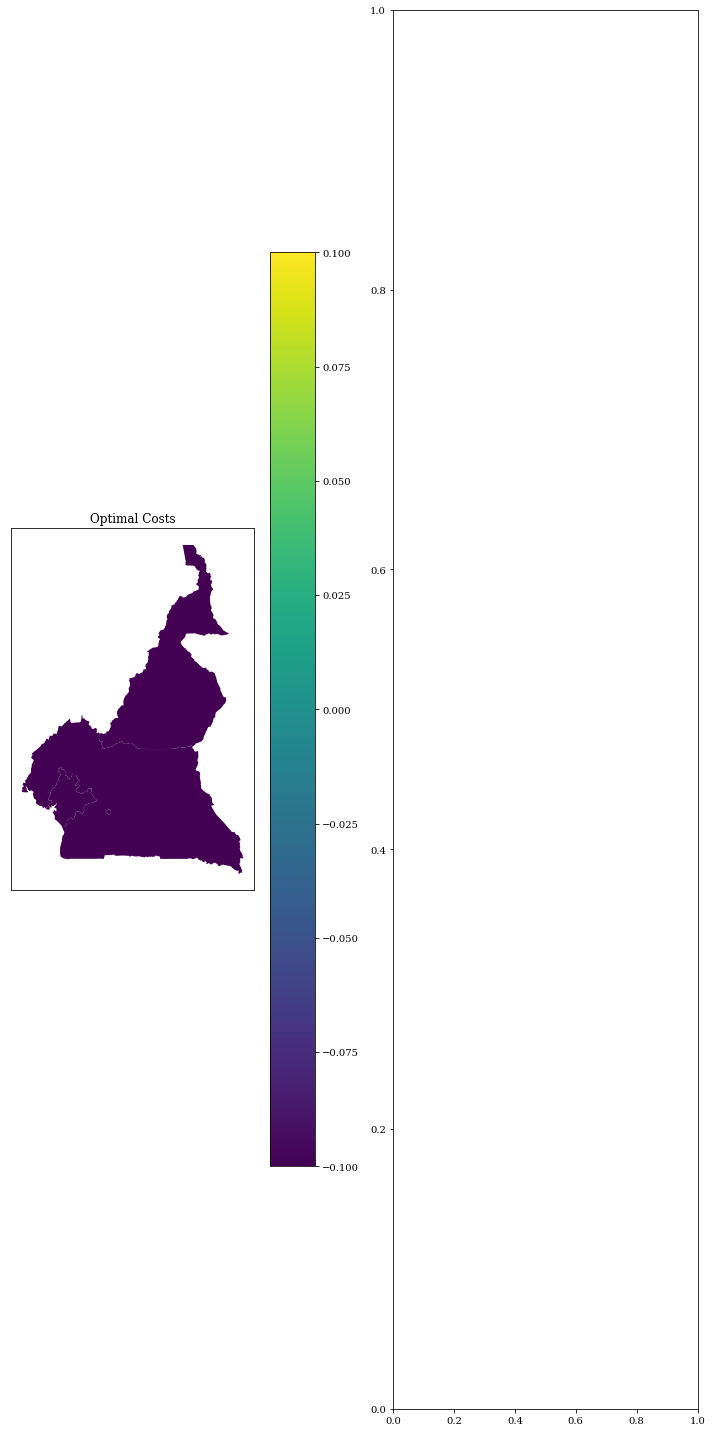

In [23]:

c.plot_chloropleth(intervention='vasoil',
                   time = [5],
                   optimum_interest='c',
                   map_df = agg_geo_df,
                   merge_key= 'space',
                   save = "map.png")


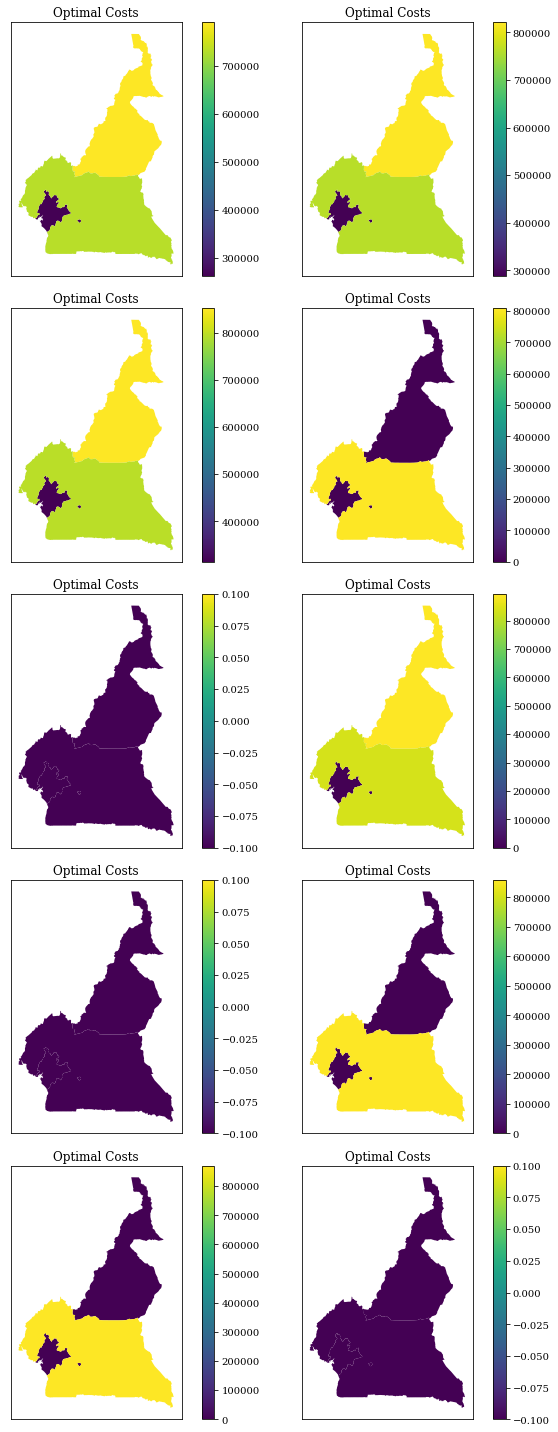

In [24]:
c.plot_chloropleth(intervention = 'vasoil',
                   optimum_interest='c',
                   map_df = agg_geo_df,
                   merge_key= 'space',
                   save = "map2.png")


